# load data

In [16]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

def load_data(root_path, test_size=0.2, random_state=42):
    """
    加载预处理的手势数据，并拆分为训练集和测试集。
    
    参数：
    root_path (str): 存储 processed_gesture_data.npy 和 gesture_labels.npy 的根目录
    test_size (float): 测试集比例，默认 20%
    random_state (int): 随机种子，确保可复现性
    
    返回：
    X_train, X_test, y_train, y_test: 训练集和测试集的数据及标签
    """
    data_path = os.path.join(root_path, "processed_gesture_data.npy")
    label_path = os.path.join(root_path, "gesture_labels.npy")
    
    if not os.path.exists(data_path) or not os.path.exists(label_path):
        raise FileNotFoundError("Processed gesture data or labels not found. Please run process_all_gesture_files first.")
    
    print("Loading processed data...")
    X = np.load(data_path,allow_pickle=True)
    y = np.load(label_path,allow_pickle=True)
    
    print(f"Data shape: {X.shape}, Labels shape: {y.shape}")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test

data_folder = r"new_collect\fzh"  
X_train, X_test, y_train, y_test = load_data(data_folder)


Loading processed data...
Data shape: (577, 19, 100, 10), Labels shape: (577,)
Training set: (461, 19, 100, 10), Testing set: (116, 19, 100, 10)


In [2]:
import random

import numpy as np

def shift_data(X, shift_steps=5, direction="right"):
    """
    对时序数据进行平移（Shift Data）

    参数：
    - X: np.array, 形状 (samples, timesteps, features)，EMG/IMU 时序数据
    - shift_steps: int, 平移的步数（时间步）
    - direction: str, "right"（向前）或 "left"（向后）

    返回：
    - X_shifted: np.array, 形状 (samples, timesteps, features)，平移后的数据
    """
    X_shifted = np.zeros_like(X)

    if direction == "right":
        X_shifted[:, shift_steps:, :] = X[:, :-shift_steps, :]
    elif direction == "left":
        X_shifted[:, :-shift_steps, :] = X[:, shift_steps:, :]
    else:
        raise ValueError("direction must be 'right' or 'left'.")

    return X_shifted

def augment_shifted_data(X, num_versions=5, max_shift=10):
    """
    创建多个不同 shift 版本的数据集（数据增强）

    参数：
    - X: np.array, 形状 (samples, timesteps, features)，原始数据
    - num_versions: int, 生成不同 shift 版本的数量
    - max_shift: int, 最大 shift 范围（随机 1~max_shift）

    返回：
    - X_augmented: np.array, 形状 (samples * num_versions, timesteps, features)
    """
    X_augmented = []
    
    for _ in range(num_versions):
        shift_steps = random.randint(1, max_shift)  # 随机 shift 1~max_shift
        direction = random.choice(["right", "left"])  # 随机左移或右移
        X_shifted = shift_data(X, shift_steps, direction)
        X_augmented.append(X_shifted)
    
    return np.concatenate(X_augmented, axis=0)

X_train = augment_shifted_data(X_train, num_versions=3, max_shift=10)
y_train = np.tile(y_train, 3)  # 复制标签

X_test = augment_shifted_data(X_test, num_versions=3, max_shift=10)
y_test = np.tile(y_test, 3)  # 复制标签


# load processed data

In [12]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

import os
import numpy as np
from sklearn.model_selection import train_test_split

def load_data(root_path, test_size=0.2, random_state=42):
    """Loads gesture dataset from multiple subfolders and splits into train/test sets."""
    
    X_list = []
    y_list = []
    for subfolder in os.listdir(root_path):
        subfolder_path = os.path.join(root_path, subfolder)
        if os.path.isdir(subfolder_path):
            data_path = os.path.join(subfolder_path, "processed_gesture_data.npy")
            label_path = os.path.join(subfolder_path, "gesture_labels.npy")
            
            if not os.path.exists(data_path) or not os.path.exists(label_path):
                print(f"Warning: {subfolder} does not have required files.")
                continue

            print(f"Loading data from {subfolder}...")
            X = np.load(data_path, allow_pickle=True)
            y = np.load(label_path, allow_pickle=True)
            
            print(f"Data shape for {subfolder}: {X.shape}, Labels shape: {y.shape}")
            
            X_list.append(X)
            y_list.append(y)
    
    X_all = np.concatenate(X_list, axis=0)
    y_all = np.concatenate(y_list, axis=0)
    
    print(f"Combined data shape: {X_all.shape}, Combined labels shape: {y_all.shape}")
    
    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=test_size, random_state=random_state, stratify=y_all)
    
    print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test


def extract_emg_features(signal, fs=1000):
    """Extracts features from an EMG signal (100 time steps)."""
    mav = np.mean(np.abs(signal))  # Mean Absolute Value
    rms = np.sqrt(np.mean(signal**2))  # Root Mean Square
    var = np.var(signal)  # Variance
    zc = np.sum(np.diff(np.sign(signal)) != 0)  # Zero Crossing Count
    wl = np.sum(np.abs(np.diff(signal)))  # Waveform Length

    # Frequency-domain features using FFT
    fft_vals = np.fft.rfft(signal)
    freqs = np.fft.rfftfreq(len(signal), d=1/fs)
    power = np.abs(fft_vals)**2
    total_power = np.sum(power)
    mean_freq = np.sum(freqs * power) / total_power if total_power else 0

    cumsum_power = np.cumsum(power)
    median_freq = freqs[np.where(cumsum_power >= total_power/2)[0][0]] if total_power else 0

    return np.array([mav, rms, var, zc, wl, mean_freq, median_freq])

def synthesize_time_series(features, num_timesteps=100):
    """
    Generates a synthetic time series of length `num_timesteps` from extracted features.
    Uses Gaussian noise centered at the mean feature values.
    """
    synthesized_signal = np.zeros((num_timesteps,))
    
    for i, feature in enumerate(features):
        synthesized_signal += feature * np.sin(2 * np.pi * (i + 1) * np.linspace(0, 1, num_timesteps))
    
    return synthesized_signal + np.random.normal(0, 0.05, num_timesteps)  # Add small noise

def replace_emg_with_synthetic_data(X, fs=1000):
    """
    Replaces the first 4 EMG channels in each window with synthesized time series
    generated from extracted features, while keeping the last 6 IMU channels unchanged.

    Parameters:
    - X: Shape (num_samples, num_windows, num_timesteps, num_channels)
    - fs: Sampling frequency

    Returns:
    - X_new: Same shape as X, but with EMG channels replaced by synthetic features
    """
    num_samples, num_windows, num_timesteps, num_channels = X.shape
    new_X = np.copy(X)  # Keep the original structure

    for i in range(num_samples):
        for j in range(num_windows):
            for ch in range(10):  # Replace only the first 4 EMG channels
                features = extract_emg_features(X[i, j, :, ch], fs)
                new_X[i, j, :, ch] = synthesize_time_series(features, num_timesteps)

    return new_X

# Load original data
data_folder = r"new_collect"  
X_train, X_test, y_train, y_test = load_data(data_folder)

# Replace EMG channels with synthesized time series
X_train_new = replace_emg_with_synthetic_data(X_train, fs=1000)
X_test_new = replace_emg_with_synthetic_data(X_test, fs=1000)

print(f"New training data shape: {X_train_new.shape}")
print(f"New testing data shape: {X_test_new.shape}")


Loading data from fzh...
Data shape for fzh: (577, 19, 100, 10), Labels shape: (577,)
Loading data from gt...
Data shape for gt: (575, 19, 100, 10), Labels shape: (575,)
Loading data from gza...
Data shape for gza: (575, 19, 100, 10), Labels shape: (575,)
Combined data shape: (1727, 19, 100, 10), Combined labels shape: (1727,)
Training set: (1381, 19, 100, 10), Testing set: (346, 19, 100, 10)
New training data shape: (1381, 19, 100, 10)
New testing data shape: (346, 19, 100, 10)


# load selected data

In [2]:
# import os
# import numpy as np
# from sklearn.model_selection import train_test_split

# def load_data(root_path, selected_labels=None, test_size=0.2, random_state=42):
#     """
#     加载预处理的手势数据，并拆分为训练集和测试集，支持选择特定的标签。
    
#     参数：
#     - root_path (str): 存储 `processed_gesture_data.npy` 和 `gesture_labels.npy` 的根目录
#     - selected_labels (list[int] or None): 选择加载的标签列表，例如 [1, 4, 6, 7]。如果 None，则加载所有数据。
#     - test_size (float): 测试集比例，默认 20%
#     - random_state (int): 随机种子，确保可复现性
    
#     返回：
#     - X_train, X_test, y_train, y_test: 训练集和测试集的数据及标签
#     """
#     data_path = os.path.join(root_path, "processed_gesture_data.npy")
#     label_path = os.path.join(root_path, "gesture_labels.npy")
    
#     if not os.path.exists(data_path) or not os.path.exists(label_path):
#         raise FileNotFoundError("Processed gesture data or labels not found. Please run process_all_gesture_files first.")
    
#     print("Loading processed data...")
#     X = np.load(data_path, allow_pickle=True)
#     y = np.load(label_path, allow_pickle=True)
    
#     print(f"Original Data shape: {X.shape}, Labels shape: {y.shape}")

#     # 选择指定标签的数据
#     if selected_labels is not None:
#         selected_labels = set(selected_labels)  # 转换为集合加速查询
#         mask = np.isin(y, list(selected_labels))  # 选择符合标签的数据
#         X = X[mask]
#         y = y[mask]
#         print(f"Filtered Data shape (after selecting labels {selected_labels}): {X.shape}")

#     # 划分训练集和测试集
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=test_size, random_state=random_state, stratify=y
#     )

#     print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")
    
#     return X_train, X_test, y_train, y_test

# # 示例调用：加载所有数据
# data_folder = r"new_collect\fzh"
# X_train, X_test, y_train, y_test = load_data(data_folder)

# # 示例调用：只加载选定的标签
# selected_labels = [1, 4, 6, 7]
# X_train, X_test, y_train, y_test = load_data(data_folder, selected_labels=selected_labels)


Loading processed data...
Original Data shape: (325, 19, 100, 10), Labels shape: (325,)
Training set: (260, 19, 100, 10), Testing set: (65, 19, 100, 10)
Loading processed data...
Original Data shape: (325, 19, 100, 10), Labels shape: (325,)
Filtered Data shape (after selecting labels {1, 4, 6, 7}): (100, 19, 100, 10)
Training set: (80, 19, 100, 10), Testing set: (20, 19, 100, 10)


# cnn

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D

X_train = np.nan_to_num(X_train, nan=0.0)
X_test = np.nan_to_num(X_test, nan=0.0)
y_train = np.nan_to_num(y_train, nan = 0.0)
y_test = np.nan_to_num(y_test, nan = 0.0)
# **获取数据形状**
num_batches = X_train.shape[0]  # batch 维度
num_windows = X_train.shape[1]  # 时间步（窗口数 59）
num_features = X_train.shape[2]  # 特征数（15）
num_channels = X_train.shape[3]  # 通道数（1）

# **检测类别数量**
unique_classes = np.unique(y_train)
num_classes = len(unique_classes)  # 确保类别数正确

print(f"Corrected Classes: {num_classes}, Batches: {num_batches}, Windows: {num_windows}, Features: {num_features}, Channels: {num_channels}")

# **保持 X 形状**
X_train = X_train.reshape(num_batches, num_windows, num_features, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_windows, num_features, num_channels)
X_train = X_train[:,:,:,:]
X_test = X_test[:,:,:,:]

# print(X_train.shape)

num_features = X_train.shape[2] 
num_channels = X_train.shape[3]
# **标签编码**
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)  # 转换成 0,1,2
y_test = encoder.transform(y_test)

# **转换为 One-Hot**
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")  # (batch, 59, 15, 1) (batch, 3)
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")  # (batch, 59, 15, 1) (batch, 3)


X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)  # (batch_size, 29, 40)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)  

# # print(num_features)
# # **构建 LSTM 处理通道的模型**

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(num_windows, num_features * num_channels)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  # 多分类输出
])

from tensorflow.keras.callbacks import LearningRateScheduler
def lr_schedule(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.9  # 每 10 个 epoch，学习率减半
    return lr

# **编译模型**
model.compile(
    optimizer=Adam(learning_rate=0.001),  # 初始学习率
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# **使用回调函数**
lr_callback = LearningRateScheduler(lr_schedule)

# **训练时加上 callback**
history = model.fit(X_train, y_train, epochs=100, callbacks=[lr_callback], validation_data=(X_test, y_test))


# **测试模型**
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# **计算准确率**
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Test Accuracy: {accuracy:.4f}")

# **保存模型**
model.save("cnn_emg_model2.h5")
print("Model saved as cnn_emg_model.h5")


Corrected Classes: 24, Batches: 1381, Windows: 19, Features: 100, Channels: 10
X_train shape: (1381, 19, 100, 10), y_train shape: (1381, 24)
X_test shape: (346, 19, 100, 10), y_test shape: (346, 24)
Epoch 1/100
44/44 [==============================] - 4s 26ms/step - loss: 3.2848 - accuracy: 0.0999 - val_loss: 2.9768 - val_accuracy: 0.0896 - lr: 0.0010
Epoch 2/100
44/44 [==============================] - 1s 18ms/step - loss: 2.7651 - accuracy: 0.1716 - val_loss: 2.5831 - val_accuracy: 0.2341 - lr: 0.0010
Epoch 3/100
44/44 [==============================] - 1s 22ms/step - loss: 2.3828 - accuracy: 0.2781 - val_loss: 2.1238 - val_accuracy: 0.4046 - lr: 0.0010
Epoch 4/100
44/44 [==============================] - 1s 20ms/step - loss: 2.0482 - accuracy: 0.3360 - val_loss: 1.6009 - val_accuracy: 0.5202 - lr: 0.0010
Epoch 5/100
44/44 [==============================] - 1s 18ms/step - loss: 1.8465 - accuracy: 0.4004 - val_loss: 1.2764 - val_accuracy: 0.5751 - lr: 0.0010
Epoch 6/100
44/44 [=======

In [14]:
history = model.fit(X_train, y_train, epochs=100, callbacks=[lr_callback], validation_data=(X_test, y_test))
model.save("cnn_emg_model2.h5")
print("Model saved as rnn_emg_model.h5")

Epoch 1/100
44/44 [==============================] - 1s 19ms/step - loss: 0.0510 - accuracy: 0.9804 - val_loss: 0.2138 - val_accuracy: 0.9393 - lr: 3.8742e-04
Epoch 2/100
44/44 [==============================] - 1s 20ms/step - loss: 0.0503 - accuracy: 0.9855 - val_loss: 0.2389 - val_accuracy: 0.9249 - lr: 3.8742e-04
Epoch 3/100
44/44 [==============================] - 1s 18ms/step - loss: 0.0384 - accuracy: 0.9884 - val_loss: 0.2112 - val_accuracy: 0.9422 - lr: 3.8742e-04
Epoch 4/100
44/44 [==============================] - 1s 18ms/step - loss: 0.0564 - accuracy: 0.9841 - val_loss: 0.1805 - val_accuracy: 0.9393 - lr: 3.8742e-04
Epoch 5/100
44/44 [==============================] - 1s 21ms/step - loss: 0.0432 - accuracy: 0.9862 - val_loss: 0.1646 - val_accuracy: 0.9451 - lr: 3.8742e-04
Epoch 6/100
44/44 [==============================] - 1s 20ms/step - loss: 0.0543 - accuracy: 0.9833 - val_loss: 0.2382 - val_accuracy: 0.9451 - lr: 3.8742e-04
Epoch 7/100
44/44 [===========================

# confusion matrix

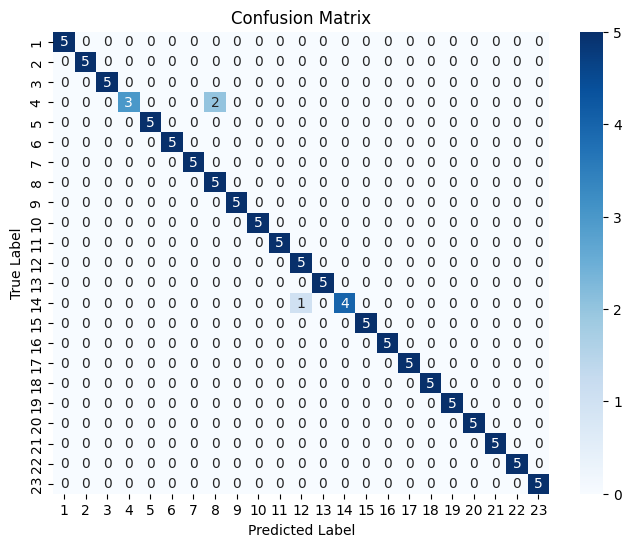

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
cm = confusion_matrix(y_test_classes, y_pred_classes)

# 可视化
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# history graph

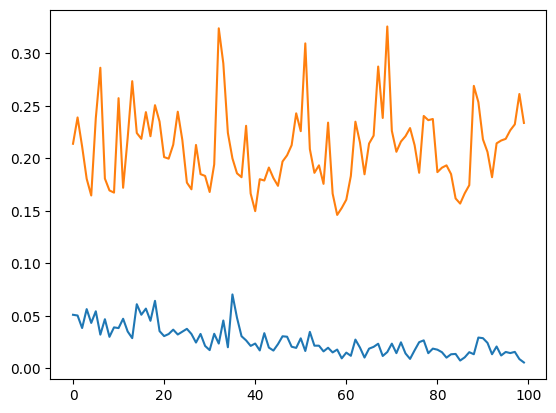

In [15]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [21]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 19, 64)            192064    
                                                                 
 batch_normalization_12 (Bat  (None, 19, 64)           256       
 chNormalization)                                                
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 9, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 9, 128)            24704     
                                                                 
 batch_normalization_13 (Bat  (None, 9, 128)           512       
 chNormalization)                                                
                                                      

In [38]:
""" detect action """
import numpy as np
def detect_action(X):
    if np.max(X[:,0:3,:,8])>5000 or np.max(X[:,0:3,:,9])>5000:
        return True, np.max(X[:,1,:,8]), np.max(X[:,1,:,9])
    else:
        return False, np.max(X[:,1,:,8]), np.max(X[:,1,:,9])
# X_train
flag = True
cnt = 0
for i in range(X_train.shape[0]):
    F, max1, max2 = detect_action(X_train[i].reshape(1,X_train.shape[1],X_train.shape[2],X_train.shape[3]))
    if not F:
        print(i,max1,max2,y_train[i])
        cnt+=1
        flag = False
print(flag,cnt)

17 38.0 48.0 7
42 293.0 307.0 11
44 75.0 341.0 10
61 48.0 120.0 9
71 84.0 121.0 10
73 640.0 3884.0 5
84 47.0 41.0 14
92 39.0 98.0 11
102 27.881881881882 182.5115115115114 11
103 217.0 207.0 6
110 5.0 97.0 7
139 27.0 53.0 1
143 31.0 68.0 9
148 33.0 95.0 18
165 68.0 160.0 7
166 -6.0 24.0 18
208 112.0 35.0 10
231 117.0 254.0 5
251 38.0 141.0 18
269 33.0 80.0 13
300 40.0 39.0 14
315 155.0 312.0 10
414 357.0 634.0 22
432 82.0 68.0 12
433 41.0 47.0 11
437 36.0 91.0 12
False 26


(100, 10)
(100, 10)


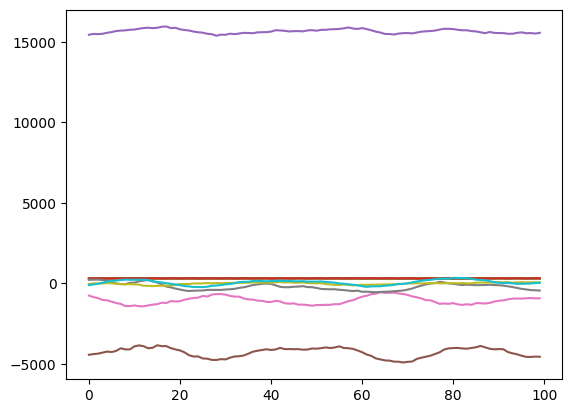

In [43]:
from matplotlib import pyplot as plt
idx = 44
X= X_train[idx,0,:,:]
for i in range(1,19):
    X = np.concatenate([X, X_train[idx,i,100:,:]], axis = 0)
print(X.shape)
for i in range(10):
    plt.plot(X[:,i])
plt.show()


In [39]:
print(y_train[44 ])

10
